<a target="_blank" href="https://colab.research.google.com/github/santineiraher/HE2_Consultor-a_IA_Responsable/blob/main/Semana%2004/HE2_clasificacion.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# HE2 Semana 04: Clasificación con `adult.csv`

Práctica técnica y compacta de clasificación supervisada para predecir ingreso (`<=50K` vs `>50K`).

**Objetivos del cuaderno**
- Construir un pipeline reproducible de clasificación binaria.
- Comparar `Logit`, `KNN` y `SVM` con el mismo preprocesamiento.
- Evaluar con métricas más allá de accuracy (`precision`, `recall`, `f1`, `roc_auc`).
- Hacer tuning con `GridSearchCV(scoring='f1')`.
- Mostrar cómo el umbral cambia errores y costo esperado.


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

TARGET_COL = "income"
RANDOM_STATE = 1999
TEST_SIZE = 0.2
SCORING_MAIN = "f1"

print("Configuración cargada.")
print({
    "TARGET_COL": TARGET_COL,
    "RANDOM_STATE": RANDOM_STATE,
    "TEST_SIZE": TEST_SIZE,
    "SCORING_MAIN": SCORING_MAIN,
})


Configuración cargada.
{'TARGET_COL': 'income', 'RANDOM_STATE': 1999, 'TEST_SIZE': 0.2, 'SCORING_MAIN': 'f1'}


## 1. Carga de datos

In [2]:
url = "https://raw.githubusercontent.com/DataResponsibly/Datasets/master/AdultIncomeData/adult.csv"
df_raw = pd.read_csv(url)

print("Shape original:", df_raw.shape)
print("Primeras filas:")
display(df_raw.head())

print("Tipos de dato:")
display(df_raw.dtypes.value_counts())


Shape original: (32561, 15)
Primeras filas:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Tipos de dato:


str      9
int64    6
Name: count, dtype: int64

## 2. Limpieza mínima y definición del target

In [6]:
df = df_raw.copy()

# Reemplazar marcador de faltantes y eliminar filas incompletas
missing_token = " ?"
df = df.replace(missing_token, np.nan)

print("Filas con faltantes antes de dropna:", df.isna().any(axis=1).sum())
df = df.dropna().copy()
print("Shape luego de dropna:", df.shape)

# Estandarizar texto del target y crear variable binaria
income_clean = ( # method chaining in pandas
    df[TARGET_COL]
    .astype(str) # hago que sea string
    .str.strip() # strip elimina los espacios al inicio o al final
    .str.replace(".", "", regex=False) 
)
y = income_clean.str.contains(r">50K").astype(int)

X = df.drop(columns=[TARGET_COL])

print("Valores únicos de y:", sorted(y.unique().tolist()))
if set(y.unique()) != {0, 1}:
    raise ValueError("El target binario no quedó en {0,1}.")

print("Balance de clases (proporción):")
display(y.value_counts(normalize=True).rename("proportion").to_frame())

if X.isna().sum().sum() > 0:
    raise ValueError("Quedaron NaN en X después de la limpieza.")

print("OK: limpieza validada (sin NaN en X, y binaria).")


Filas con faltantes antes de dropna: 2399
Shape luego de dropna: (30162, 15)
Valores únicos de y: [0, 1]
Balance de clases (proporción):


,proportion
income,
0,0.751078
1,0.248922


OK: limpieza validada (sin NaN en X, y binaria).


## 3. Train/Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Tamaños:")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train mean:", y_train.mean().round(4), "| y_test mean:", y_test.mean().round(4))


Tamaños:
X_train: (24129, 14) | X_test: (6033, 14)
y_train mean: 0.2489 | y_test mean: 0.249


## 4. Preprocesamiento reusable

In [8]:
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()

print("Numéricas:", len(numeric_features))
print("Categóricas:", len(categorical_features))

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

display(pd.DataFrame({
    "numeric_features": pd.Series(numeric_features),
    "categorical_features": pd.Series(categorical_features),
}))


Numéricas: 6
Categóricas: 8


,numeric_features,categorical_features
0,age,workclass
1,fnlwgt,education
2,education-num,marital-status
3,capital-gain,occupation
4,capital-loss,relationship
5,hours-per-week,race
6,NaN,sex
7,NaN,native-country


## 5. Funciones auxiliares (métricas y umbral)

In [9]:
def evaluate_model(y_true, y_pred, y_prob):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
    }


def evaluate_thresholds(y_true, y_prob, thresholds, c_fp=1, c_fn=2):
    """
    Evalúa métricas y costo total para múltiples umbrales de clasificación.
    
    Args:
        y_true: etiquetas reales (0/1)
        y_prob: probabilidades predichas para la clase positiva
        thresholds: lista de umbrales a evaluar
        c_fp: costo unitario de falsos positivos (default=1)
        c_fn: costo unitario de falsos negativos (default=2)
    
    Returns:
        DataFrame con tn, fp, fn, tp, precision, recall, f1 y costo_total por umbral
    """
    rows = []
    for t in thresholds:
        y_pred_t = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
        rows.append({
            "threshold": t,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "precision": precision_score(y_true, y_pred_t, zero_division=0),
            "recall": recall_score(y_true, y_pred_t, zero_division=0),
            "f1": f1_score(y_true, y_pred_t, zero_division=0),
            "cost_total": c_fp * fp + c_fn * fn,
        })
    return pd.DataFrame(rows).sort_values("threshold").reset_index(drop=True)


## 6. Modelos base: Logit, KNN, SVM

In [10]:
models = {
    "logit": LogisticRegression(max_iter=2000, class_weight=None),
    "knn": KNeighborsClassifier(),
    "svm": SVC(probability=True),
}

base_results = []
base_confusions = {}
fitted_base_models = {}

for model_name, model_obj in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model_obj),
    ])
    pipe.fit(X_train, y_train)

    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    metrics_dict = evaluate_model(y_test, y_pred, y_prob)
    metrics_dict["model"] = model_name
    base_results.append(metrics_dict)

    cm = confusion_matrix(y_test, y_pred)
    base_confusions[model_name] = cm
    fitted_base_models[model_name] = pipe

base_results_df = pd.DataFrame(base_results).sort_values("f1", ascending=False).reset_index(drop=True)
print("Resultados base (ordenados por F1):")
display(base_results_df)


Resultados base (ordenados por F1):


,accuracy,precision,recall,f1,roc_auc,model
0,0.852810,0.757983,0.600533,0.670134,0.901138,svm
1,0.846345,0.729816,0.607856,0.663276,0.906958,logit
2,0.832090,0.677818,0.620506,0.647897,0.859309,knn


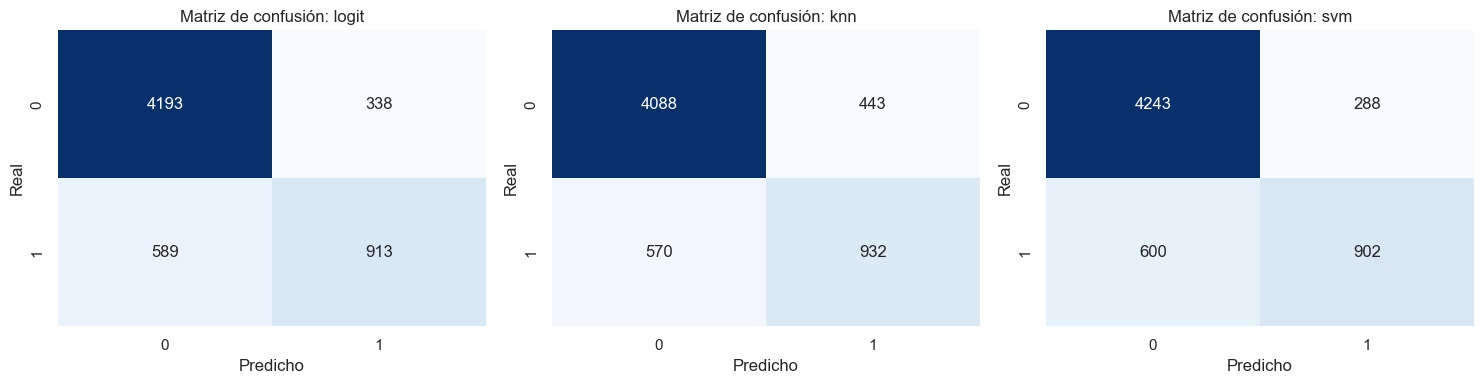

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, model_name in zip(axes, ["logit", "knn", "svm"]):
    cm = base_confusions[model_name]
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", ax=ax)
    ax.set_title(f"Matriz de confusión: {model_name}")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
plt.tight_layout()
plt.show()

for model_name in ["logit", "knn", "svm"]:
    cm_sum = base_confusions[model_name].sum()
    assert cm_sum == len(y_test), f"La matriz de {model_name} no suma len(y_test)."

## 7. Tuning por F1 con GridSearchCV

En esta sección, `GridSearchCV` prueba combinaciones de hiperparámetros y elige la que maximiza `F1` en validación cruzada.

- **Logistic Regression (`logit`)**
  - `C`: inverso de la regularización. `C` pequeño = más regularización (modelo más simple); `C` grande = menos regularización (modelo más flexible).
  - `penalty`: tipo de regularización. Aquí usamos `l2` (penaliza coeficientes grandes para reducir sobreajuste).

- **K-Nearest Neighbors (`knn`)**
  - `n_neighbors`: número de vecinos `k` usados para clasificar.
  - `weights`: cómo ponderar vecinos.
    - `uniform`: todos los vecinos pesan igual.
    - `distance`: vecinos más cercanos pesan más.
  - `p`: métrica de Minkowski.
    - `p=1`: distancia Manhattan.
    - `p=2`: distancia Euclidiana.

- **Support Vector Machine (`svm`)**
  - `kernel`: transforma el espacio de entrada.
    - `linear`: frontera lineal.
    - `rbf`: frontera no lineal.
  - `C`: controla el tradeoff entre margen amplio y errores de clasificación.
    - `C` grande: penaliza más errores (ajuste más estricto).
    - `C` pequeño: permite más errores (más regularización).
  - `gamma` (solo con `rbf`): alcance de influencia de cada punto.
    - `gamma` alto: influencia local (frontera más compleja).
    - `gamma` bajo: influencia más global (frontera más suave).
    - `"scale"`: valor automático recomendado por `scikit-learn` según la varianza de los datos.



In [12]:
param_grids = {
    "logit": {
        "model__C": [0.1, 1.0, 10.0],               
        "model__penalty": ["l2"],                   # ridge
    },
    "knn": {
        "model__n_neighbors": [5, 11, 21],          
        "model__weights": ["uniform", "distance"],  
        "model__p": [1, 2],                         
    },
    "svm": [
        {
            "model__kernel": ["linear"],
            "model__C": [0.5, 1.0, 5.0],
        },
        {
            "model__kernel": ["rbf"],
            "model__C": [0.5, 1.0, 5.0],
            "model__gamma": ["scale", 0.1, 0.01],
        },
    ],
}

cv_results = []
best_estimators = {}

for model_name, model_obj in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model_obj),
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[model_name],
        scoring=SCORING_MAIN,
        cv=5,
        n_jobs=-1,
        refit=True,
        verbose=0,
    )

    grid.fit(X_train, y_train)

    best_pipe = grid.best_estimator_
    y_prob = best_pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    metrics_dict = evaluate_model(y_test, y_pred, y_prob)
    metrics_dict.update({
        "model": model_name,
        "best_cv_f1": grid.best_score_,
        "best_params": grid.best_params_,
    })

    cv_results.append(metrics_dict)
    best_estimators[model_name] = best_pipe

cv_results_df = pd.DataFrame(cv_results).sort_values("f1", ascending=False).reset_index(drop=True)
print("Resultados tuned (ordenados por F1 en test):")
display(cv_results_df[["model", "best_cv_f1", "accuracy", "precision", "recall", "f1", "roc_auc", "best_params"]])


Resultados tuned (ordenados por F1 en test):


,model,best_cv_f1,accuracy,precision,recall,f1,roc_auc,best_params
0,svm,0.670432,0.852478,0.754576,0.603862,0.670858,0.891526,"{'model__C': 5.0, 'model__gamma': 'scale', 'mo..."
1,logit,0.664858,0.846345,0.729816,0.607856,0.663276,0.906958,"{'model__C': 1.0, 'model__penalty': 'l2'}"
2,knn,0.648749,0.840046,0.701124,0.623169,0.659852,0.886144,"{'model__n_neighbors': 11, 'model__p': 2, 'mod..."


## 8. Mejor modelo e interpretación corta

In [13]:
best_row = cv_results_df.iloc[0]
best_model_name = best_row["model"]
best_model = best_estimators[best_model_name]

print("Mejor modelo según F1 en test:", best_model_name)
print("Mejores hiperparámetros:")
print(best_row["best_params"])
print("Métricas test del mejor modelo:")
display(best_row[["accuracy", "precision", "recall", "f1", "roc_auc"]].to_frame("value"))

if best_row["precision"] > best_row["recall"]:
    comment = "Tradeoff observado: el modelo está más conservador (mayor precision que recall)."
elif best_row["precision"] < best_row["recall"]:
    comment = "Tradeoff observado: el modelo está más agresivo (mayor recall que precision)."
else:
    comment = "Tradeoff observado: precision y recall están balanceados."

print(comment)


Mejor modelo según F1 en test: svm
Mejores hiperparámetros:
{'model__C': 5.0, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Métricas test del mejor modelo:


,value
accuracy,0.852478
precision,0.754576
recall,0.603862
f1,0.670858
roc_auc,0.891526


Tradeoff observado: el modelo está más conservador (mayor precision que recall).


## 9. Umbral y costo asimétrico (ejemplo breve)

Usamos el mejor modelo y comparamos umbrales con costo:

$$
	\text{Costo Total} = C_{FP} \cdot FP + C_{FN} \cdot FN
$$

En el contexto de predecir si una persona gana más de 50K, un FN (predecir <=50K cuando en realidad es >50K) podría ser más costoso que un FP (predecir >50K cuando en realidad es <=50K), dependiendo del objetivo del análisis. Por ejemplo, si el objetivo es identificar personas que podrían beneficiarse de un subsidio o programa de apoyo, un FN podría significar perder la oportunidad de ayudar a alguien que realmente lo necesita, mientras que un FP podría resultar en ofrecer ayuda a alguien que no la necesita, lo cual también tiene un costo pero podría ser considerado menos grave en ciertos contextos. 

Ejemplo reproducible: `C_FP = 1`, `C_FN = 2` (FN más costoso que FP) 

In [ ]:


best_prob_test = best_model.predict_proba(X_test)[:, 1]
thresholds = [0.3, 0.5, 0.7]
C_FP = 1
C_FN = 2

threshold_table = evaluate_thresholds(
    y_true=y_test,
    y_prob=best_prob_test,
    thresholds=thresholds,
    c_fp=C_FP,
    c_fn=C_FN,
)

print("Tabla de umbral vs métricas/costo:")
display(threshold_table)

best_threshold_row = threshold_table.loc[threshold_table["cost_total"].idxmin()]
print(
    f"Umbral de menor costo: {best_threshold_row['threshold']} "
    f"(Costo={best_threshold_row['cost_total']:.0f}, FP={best_threshold_row['fp']:.0f}, FN={best_threshold_row['fn']:.0f})"
)


Tabla de umbral vs métricas/costo:


,threshold,tn,fp,fn,tp,precision,recall,f1,cost_total
0,0.3,4055,476,461,1041,0.686223,0.693076,0.689632,1398
1,0.5,4236,295,595,907,0.754576,0.603862,0.670858,1485
2,0.7,4364,167,764,738,0.815470,0.491345,0.613211,1695


Umbral de menor costo: 0.3 (Costo=1398, FP=476, FN=461)


## 10. Cierre (Semana 04)

- `Accuracy` no basta: con desbalance o costos asimétricos puede ser engañosa.
- La métrica objetivo debe reflejar prioridades del problema (aquí tuneamos por `F1`).
- Cambiar umbral cambia `FP/FN` y, por tanto, el costo esperado.
- Comparar algoritmos con el mismo pipeline de preprocesamiento mejora consistencia y trazabilidad.
